# Deprem Konumu Belirleme

In [1]:
# interaktif figürler
%matplotlib notebook

# Veri indirme
from obspy.clients.fdsn.client import Client
from obspy.clients.fdsn.mass_downloader import GlobalDomain
from obspy.clients.fdsn.mass_downloader import MassDownloader
from obspy.clients.fdsn.mass_downloader import Restrictions
from obspy import UTCDateTime

# Enlem, Boylam -> Uzaklik
from obspy.geodetics import calc_vincenty_inverse

# obspy
import obspy

# Figürler
import matplotlib.pyplot as plt
from matplotlib.widgets import SpanSelector
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import numpy as np
import glob
import os
from functools import partial
from collections import defaultdict

def makedir(dirname):
    """Klasör oluşturur, eğer var ise hata vermez."""
    try:
        os.makedirs(dirname)
    except OSError:
        pass

## Veri Hazirlama

In [2]:
def plot_map():
    """Harita icin figür hazırlayıp geri döndürür."""
    fig, ax = plt.subplots(figsize=(9, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([25, 45, 34,43], crs=ccrs.PlateCarree())
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '50m',
                                           edgecolor="black", facecolor="none")
    ax.add_feature(borders, zorder=2)
    img = plt.imread("harita/turkey.png")
    img_extent = [25, 45, 34, 43]
    ax.imshow(img, origin='upper', extent=img_extent, transform=ccrs.PlateCarree(), zorder=1)
    return fig, ax

### Seçilen Deprem

Bu uygulama için 20 Temmuz 2017 tarihli Bodrum depremi seçildi.

In [3]:
cat = obspy.read_events("20170720.xml")
origin = cat.events[0].origins[0]
print(cat)

1 Event(s) in Catalog:
2017-07-20T22:31:11.240000Z | +36.925,  +27.413 | 6.6 Mww


### Veri İndirme

Kandilli Rasathanesi ve Deprem Araştırma Enstitüsü Bölgesel Deprem-Tsunami İzleme ve Değerlendirme Merkezi'nden sismik kayıtları ve istasyon dosyalarını indireceğiz.

In [4]:
def download(eqname, t0, min_length=600):
    domain = GlobalDomain()

    restrictions = Restrictions(starttime=t0,endtime=t0+min_length,chunklength_in_sec=84600,network="*", station="*", location="", channel="BH*",
        reject_channels_with_gaps=True,minimum_length=0.0,minimum_interstation_distance_in_m=100.0)

    waveform_dir = "data/{}/waveforms".format(eqname)
    stationxml_dir = "data/{}/stations".format(eqname)
    makedir(waveform_dir)
    makedir(stationxml_dir)

    mdl = MassDownloader(providers=["http://eida.koeri.boun.edu.tr:8080"])
    # Kandilli FDSN matchtimeseries=True icin bos istasyon listesi donduruyor.
    mdl._initialized_clients["http://eida.koeri.boun.edu.tr:8080"].services["station"].pop("matchtimeseries")
    mdl.download(domain, restrictions,
                 mseed_storage=waveform_dir,
                 stationxml_storage=stationxml_dir)
    
origin = cat[0].origins[0]
download("20170720", origin.time)

[2018-11-06 21:00:26,560] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for http://eida.koeri.boun.edu.tr:8080.
[2018-11-06 21:00:27,342] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): http://eida.koeri.boun.edu.tr:8080.
[2018-11-06 21:00:27,343] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2018-11-06 21:00:27,344] - obspy.clients.fdsn.mass_downloader - INFO: Client 'http://eida.koeri.boun.edu.tr:8080' - Requesting unreliable availability.
[2018-11-06 21:00:29,700] - obspy.clients.fdsn.mass_downloader - INFO: Client 'http://eida.koeri.boun.edu.tr:8080' - Successfully requested availability (2.35 seconds)
[2018-11-06 21:00:29,896] - obspy.clients.fdsn.mass_downloader - INFO: Client 'http://eida.koeri.boun.edu.tr:8080' - Found 133 stations (399 channels).
[2018-11-06 21:00:29,900] - obspy.clients.fdsn.mass_downloader - INFO: Client 'http://eida.koeri.boun.edu.tr:8080' - Will attempt 

Istasyon bilgi (StationXML) dosyalarını okuma:

In [5]:
inv = None
for filename in glob.glob("data/20170720/stations/*.xml"):
    if inv is None:
        inv = obspy.read_inventory(filename)
    else:
        inv += obspy.read_inventory(filename)

İstasyon ve deprem konumlarının haritada gösterimi

<IPython.core.display.Javascript object>


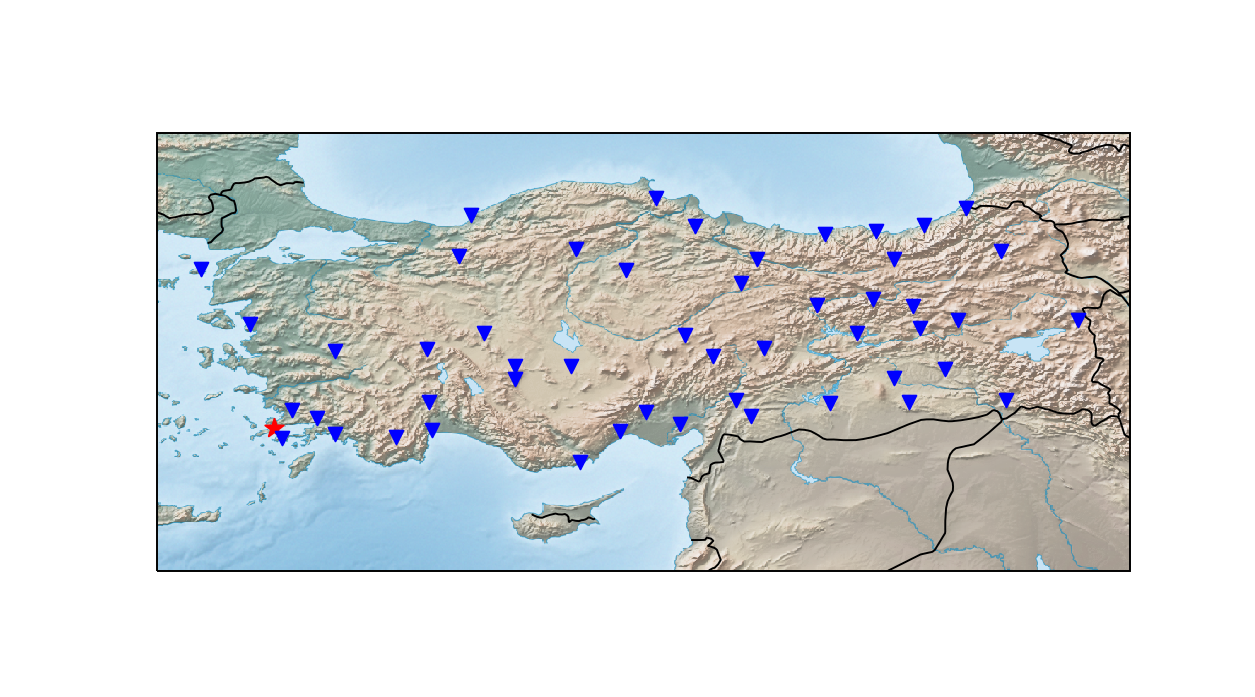

In [6]:
lats = []
lons = []
# Inventory nesnesinden Z kanallarını oku enlem ve boylamlarını kaydet
for channel in inv.get_contents()["channels"]:
    if channel.endswith("Z"):
        coords = inv.get_coordinates(channel)
        lats.append(coords["latitude"])
        lons.append(coords["longitude"])

fig, ax = plot_map()
ax.scatter(origin.longitude, origin.latitude, 100, color="r", marker="*", transform=ccrs.Geodetic(), zorder=10)
ax.scatter(lons, lats, 50, color="b", marker="v", transform=ccrs.Geodetic(),  zorder=10)

## Tek İstasyon Yöntemi

Bu yöntemde üç bileşenli tek bir istasyon kullanarak depremin konumunu belirleyeceğiz.

Öncelikle depremin istasyona olan uzaklığını P ve S varış zamanlarının arasındakı farka bakarak bulabiliriz. Normal, orta yaşlı kabuk için P ve S ilk varışları arasındaki zaman farkının 8 ile çarpımı genel olarak iyi bir uzaklık tahmini verir.

$$
D = (t_p - t_s) \times 8
$$

Uzaklık bulunduktan sonra ise azimutu bulmak için yatay bileşenlerin genlik oranları kullanılabilir.

$$
AZI = \arctan{A_E / A_N}~,
$$

$AZI$ bize episantra doğru olan backazimuth değerini verir. Ancak bu değer P ilk varışının polaritesine bağlı olarak $180^{\circ}$'lik bir belirsiz içerir. Eğer ilk varış yukarı doğru ise (sıkışma rejimi), yatay bileşenlerdeki hareket deprem merkezinden dışarıya doğrudur.

<figure>
    <img src="figures/NMSOP_single_station_location.png" width="400" height="350" alt="Tek istasyon yöntemi"/>
    <figcaption style="text-align: center">Resim 1: Tek istasyon yöntemi (Bormann, 2002)</figcaption>
</figure>

Elmalı-ANTALYA (KO.ELL) istasyonunu okuyup filtreleyelim:

In [7]:
def process(st):
    st.attach_response(inv)
    st.trim(starttime=origin.time, endtime=origin.time+600, pad=True, fill_value=0)
    low_freq = 1.0/40
    high_freq = 1.0
    # Filtre için kullanılacak sınır frekansların belirlenmesi
    pre_filt = [0.8*low_freq, low_freq, high_freq, high_freq*1.2]
    st.detrend("demean")
    st.detrend("linear")
    st.taper(0.05)
    st.remove_response(output="DISP", pre_filt=pre_filt, plot=False)

st = obspy.read("./data/20170720/waveforms/KO.ELL*")
process(st)

/home/orsvuran/.virtualenvs/obspy2/lib/python2.7/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


In [9]:
def plot_pick_and_find_dist(st, dists, trange=None):
    """Sismik kayıtları çizdirir. Fare ile bir aralık seçildiğinde
    aralığın başlangıcı P ve bitişi S geliş zamanı olarak atar. Episantra
    olan uzaklık (tp-ts)*8 formülü ile `dists` nesnesine yazar."""
    
    if trange is None:
        trange = [st[0].times()[0], st[0].times()[-1]]
    nsta = len(st)
    
    fig, axes = plt.subplots(nrows=nsta, sharex=True, figsize=(9, 2*nsta))
    
    # istasyon kanallarını nereye çizdiğini takip et
    st_axes = defaultdict(list)
    for i, tr in enumerate(st):
        axes[i].plot(tr.times(), tr.data, "k", label=tr.id)
        axes[i].legend()
        
        # Grafik sinirlarini belirle
        tmin, tmax = trange
        xmin, xmax = np.abs(tr.times()-tmin).argmin(), np.abs(tr.times()-tmax).argmin()
        ymin, ymax = np.min(tr.data[xmin:xmax])*1.2, np.max(tr.data[xmin:xmax])*1.2
        axes[i].set_xlim(tmin, tmax)
        axes[i].set_ylim(ymin, ymax)
        
        st_axes[tr.stats.station].append(i)
        
    axes[-1].set_xlabel("Zaman (sn)")
        
    ps = {}
    ss = {}
    def onselect(tmin, tmax, station):
        for i in st_axes[station]:
            # episantra olan uzaklığı bul
            dists[st[i].id] = (tmax-tmin)*8
            if i in ps:
                ps[i].pop(0).remove()
                ss[i].pop(0).remove()
            ps[i] = axes[i].plot([tmin, tmin], axes[i].get_ylim(), "r--")
            ss[i] = axes[i].plot([tmax, tmax], axes[i].get_ylim(), "r--")

    selectors = []
    for i in range(nsta):
        selectors.append(SpanSelector(axes[i], partial(onselect, station=st[i].stats.station),
                                      "horizontal", useblit=True,
                                      rectprops={"alpha":0.5, "facecolor": "red"}))
    return fig, axes, selectors

<IPython.core.display.Javascript object>


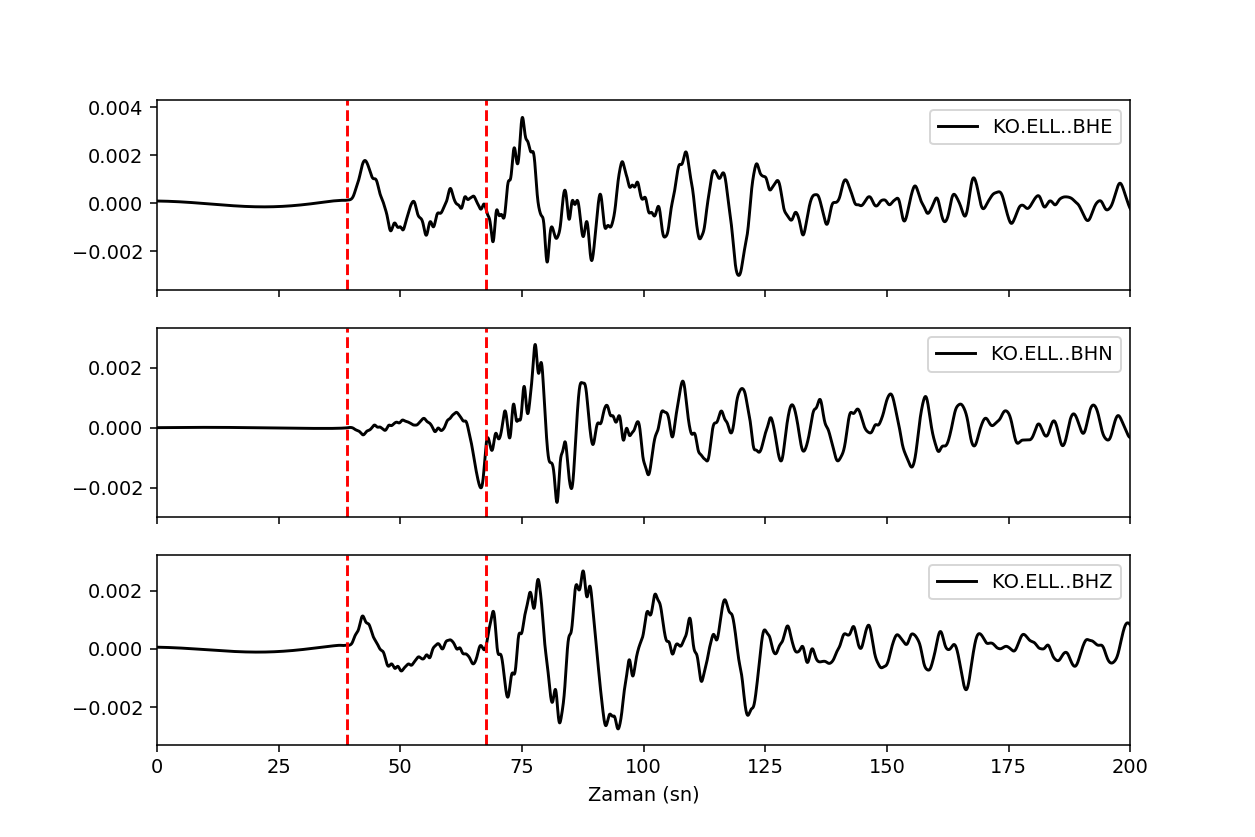

In [10]:
dists = {}
res = plot_pick_and_find_dist(st, dists, (0, 200))

In [11]:
coords = inv.get_coordinates("KO.ELL..BHZ")
dist, az, baz = calc_vincenty_inverse(coords["latitude"], coords["longitude"], origin.latitude, origin.longitude)
print("Iris çözümü için uzaklık: {:.2f} km".format(dist/1000))
print("Bulunan uzaklık: {:.2f} km".format(dists["KO.ELL..BHZ"]))

Iris çözümü için uzaklık: 223.41 km
Bulunan uzaklık: 229.39 km


In [12]:
def plot_find_amps(st, amps, trange=None):
    if trange is None:
        trange = [st[0].times()[0], st[0].times()[-1]]
    nsta = len(st)
    fig, axes = plt.subplots(nrows=nsta, sharex=True, figsize=(9, 2*nsta))
    st_axes = defaultdict(list)
    for i, tr in enumerate(st):
        axes[i].plot(tr.times(), tr.data, "k", label=tr.id)
        axes[i].legend()
        
        # Grafik sinirlarini belirle
        tmin, tmax = trange
        xmin, xmax = np.abs(tr.times()-tmin).argmin(), np.abs(tr.times()-tmax).argmin()
        ymin, ymax = np.min(tr.data[xmin:xmax])*1.2, np.max(tr.data[xmin:xmax])*1.2
        axes[i].set_xlim(tmin, tmax)
        axes[i].set_ylim(ymin, ymax)
        st_axes[tr.stats.station].append(i)
        
    axes[-1].set_xlabel("Zaman (sn)")
        
    top_amp_lines = {}
    bot_amp_lines = {}
    def onselect(tmin, tmax, station):
        for i in st_axes[station]:
            tr = st[i]
            left, right = np.abs(tr.times()-tmin).argmin(), np.abs(tr.times()-tmax).argmin()
            amin = min(tr.data[left:right])
            amax = max(tr.data[left:right])
            if np.abs(amin) > np.abs(amax):
                amps[tr.id] = amin
            else:
                amps[tr.id] = amax
            if tr.id in top_amp_lines:
                top_amp_lines[tr.id].pop(0).remove()
                bot_amp_lines[tr.id].pop(0).remove()
            top_amp_lines[tr.id] = axes[i].plot(axes[i].get_xlim(), [amin, amin], "--r")
            bot_amp_lines[tr.id] = axes[i].plot(axes[i].get_xlim(), [amax, amax], "--r")

    selectors = []
    for i in range(nsta):
        selectors.append(SpanSelector(axes[i], partial(onselect, station=st[i].stats.station),
                                      "horizontal", useblit=True,
                                      rectprops={"alpha":0.5, "facecolor": "red"}))
    return fig, axes, selectors

<IPython.core.display.Javascript object>


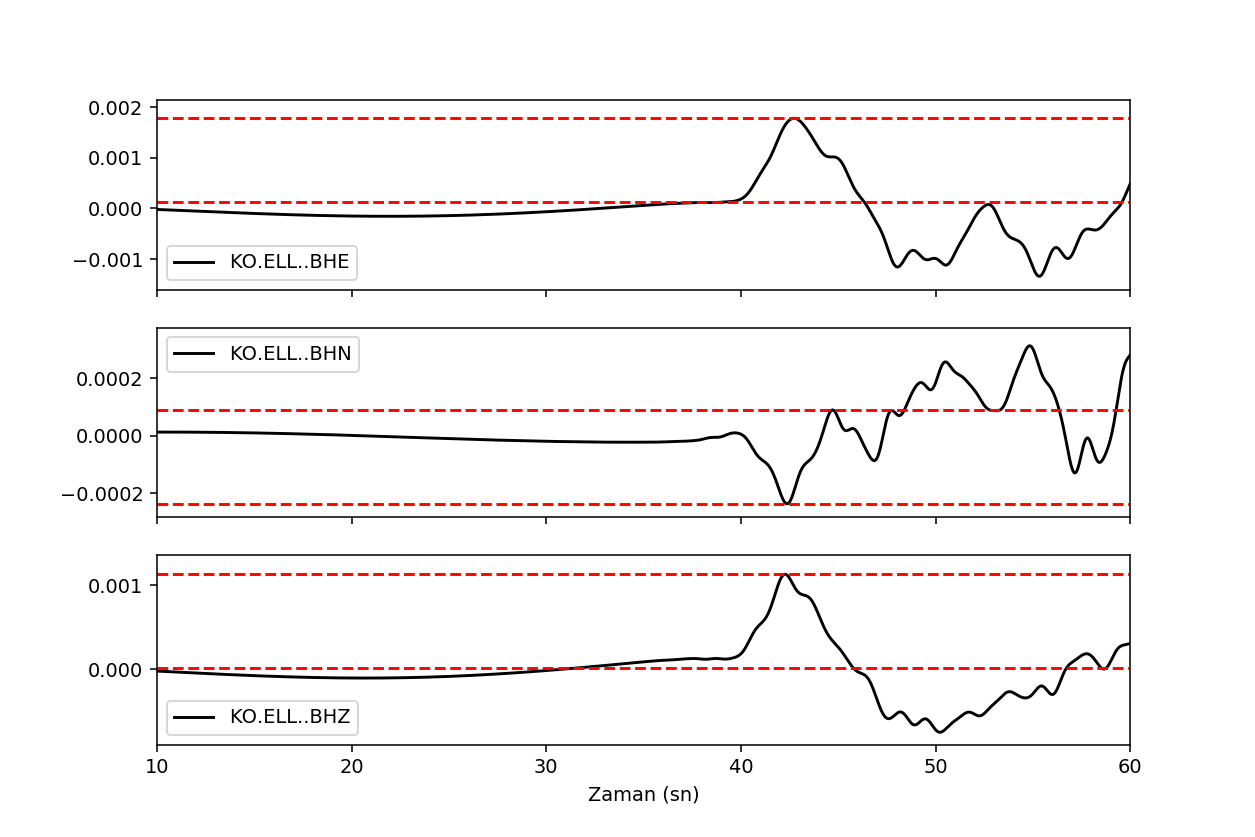

In [13]:
amps = {}
res = plot_find_amps(st, amps, (10, 60))

In [14]:
backazimuth = np.degrees(np.arctan2(amps["KO.ELL..BHE"], amps["KO.ELL..BHN"]))
print(u"backazimuth: {:.2f}°".format(backazimuth))

backazimuth: 97.56°


In [15]:
mybaz = np.arctan2(amps["KO.ELL..BHE"], amps["KO.ELL..BHN"])
myaz = mybaz+np.pi
mydist = dists["KO.ELL..BHZ"]
coords = inv.get_coordinates("KO.ELL..BHZ")

def get_point_from(lat, lon, dist, az):
    # http://www.movable-type.co.uk/scripts/latlong.html
    rlat = np.radians(lat)
    rlon = np.radians(lon)
    R = 6371 
    d = dist/R
    lat2 = np.arcsin(np.sin(rlat)*np.cos(d) + np.cos(rlat)*np.sin(d)*np.cos(az))
    lon2 = rlon + np.arctan2(np.sin(az)*np.sin(d)*np.cos(rlat),
                             np.cos(d)-np.sin(rlat)*np.sin(lat2))
    return np.degrees(lat2), np.degrees(lon2)

def get_dist_circle(lat, lon, dist):
    circle = np.linspace(0, 2*np.pi, 1000)
    cx = []
    cy = []
    for caz in circle:
        a, b = get_point_from(lat, lon, dist, caz)
        cx.append(a)
        cy.append(b)
    return cx, cy

lat2, lon2 = get_point_from(coords["latitude"], coords["longitude"], mydist, myaz)
print(lat2, lon2)

(36.99223282903418, 27.347796480430482)


<IPython.core.display.Javascript object>


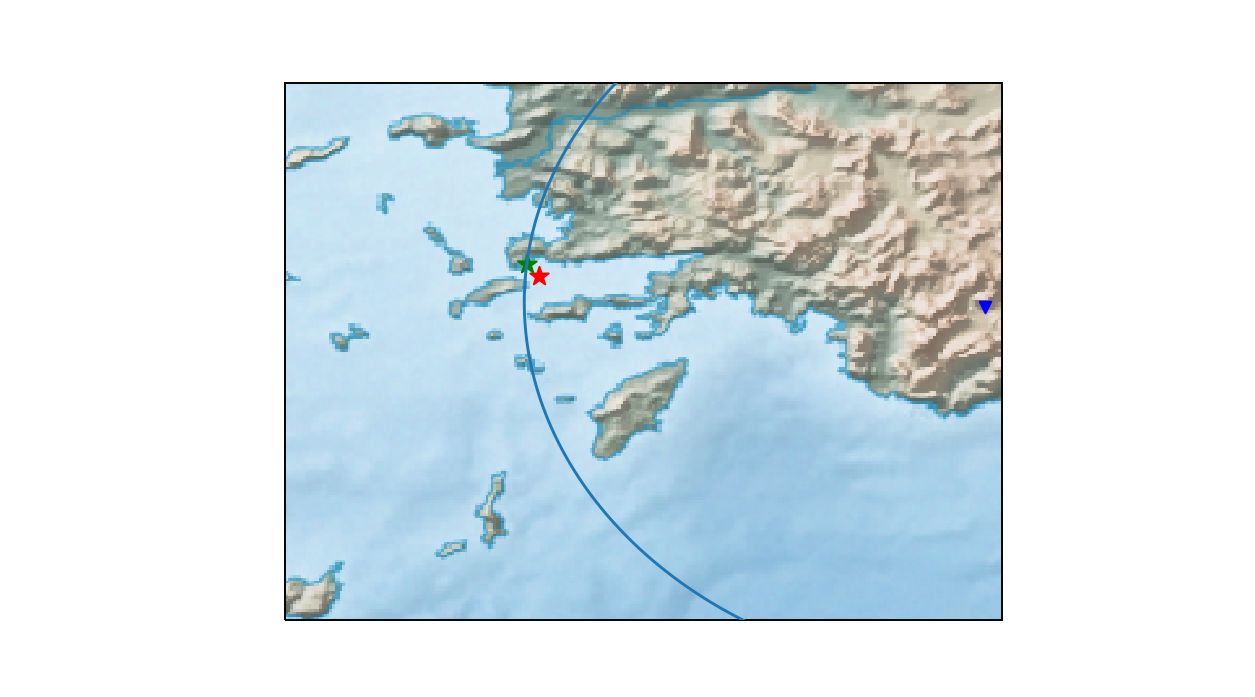

Uzaklık farkı: 9.49 km


In [16]:
fig, ax = plot_map()
ax.set_extent([26, 30, 35, 38], crs=ccrs.PlateCarree())
event = cat[0]
origin = event.origins[0]

ax.scatter(origin.longitude, origin.latitude, 100, color="r", marker="*", transform=ccrs.Geodetic(), zorder=10)
ax.scatter(lon2, lat2, 100, color="g", marker="*", transform=ccrs.Geodetic(), zorder=10)
ax.scatter(coords["longitude"], coords["latitude"], color="b", marker="v", transform=ccrs.Geodetic(), zorder=10)

cx, cy = get_dist_circle(coords["latitude"], coords["longitude"], mydist)

ax.plot(cy, cx, transform=ccrs.Geodetic(), zorder=10)

ndist, _, _ = calc_vincenty_inverse(origin.latitude, origin.longitude, lat2, lon2)
print("Uzaklık farkı: {:.2f} km".format(ndist/1000))

## Çoklu İstasyon Yöntemi

Çoklu istasyon yönteminde ise azimut hesabı yapılmadan en az üç istasyon için uzaklık hesabı yapılır ve uzaklık çemberlerinin kesişimi ile konum tahmini yapılır.

<figure>
    <img src="figures/NMSOP_circle_and_chord.png" width="285" height="250" alt="Çoklu istasyon yöntemi"/>
    <figcaption style="text-align: center">Resim 2: Çoklu istasyon yöntemi (Bormann, 2002)</figcaption>
</figure>

<IPython.core.display.Javascript object>


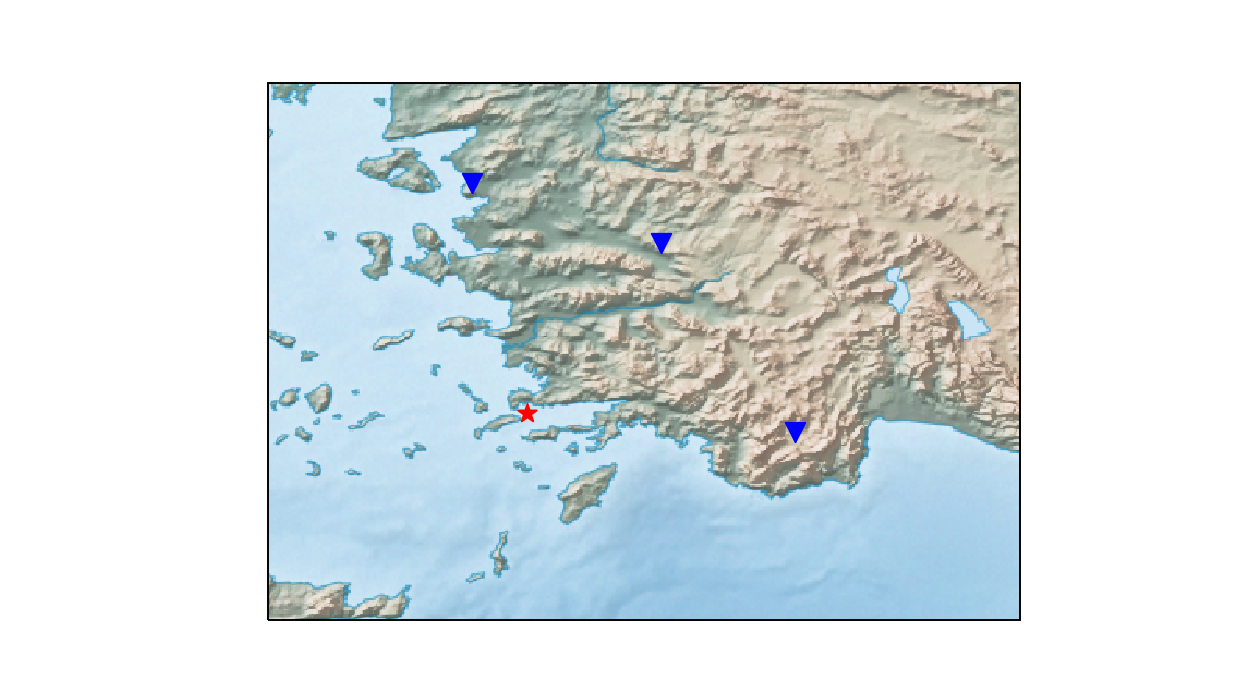

In [17]:
# KO.ELL (Elmalı-ANTALYA)
# KO.KULA (Kula-MANİSA)
# KO.DKL (Dikili-İZMİR)
station_names = ["KO.ELL", "KO.KULA", "KO.DKL"]
rlats = []
rlons = []
for sta in station_names:
    coords = inv.get_coordinates("{}..BHZ".format(sta))
    rlats.append(coords["latitude"])
    rlons.append(coords["longitude"])

fig, ax = plot_map()
ax.scatter(origin.longitude, origin.latitude, 100, color="r", marker="*", transform=ccrs.Geodetic(), zorder=10)
ax.scatter(rlons, rlats, 100, color="b", marker="v", transform=ccrs.Geodetic(), zorder=10)
ax.set_extent([25, 32, 35, 40])

In [18]:
st = None
for sta in station_names:
    if st is None:
        st = obspy.read("./data/20170720/waveforms/{}*".format(sta))
    else:
        st += obspy.read("./data/20170720/waveforms/{}*".format(sta))

process(st)

<IPython.core.display.Javascript object>


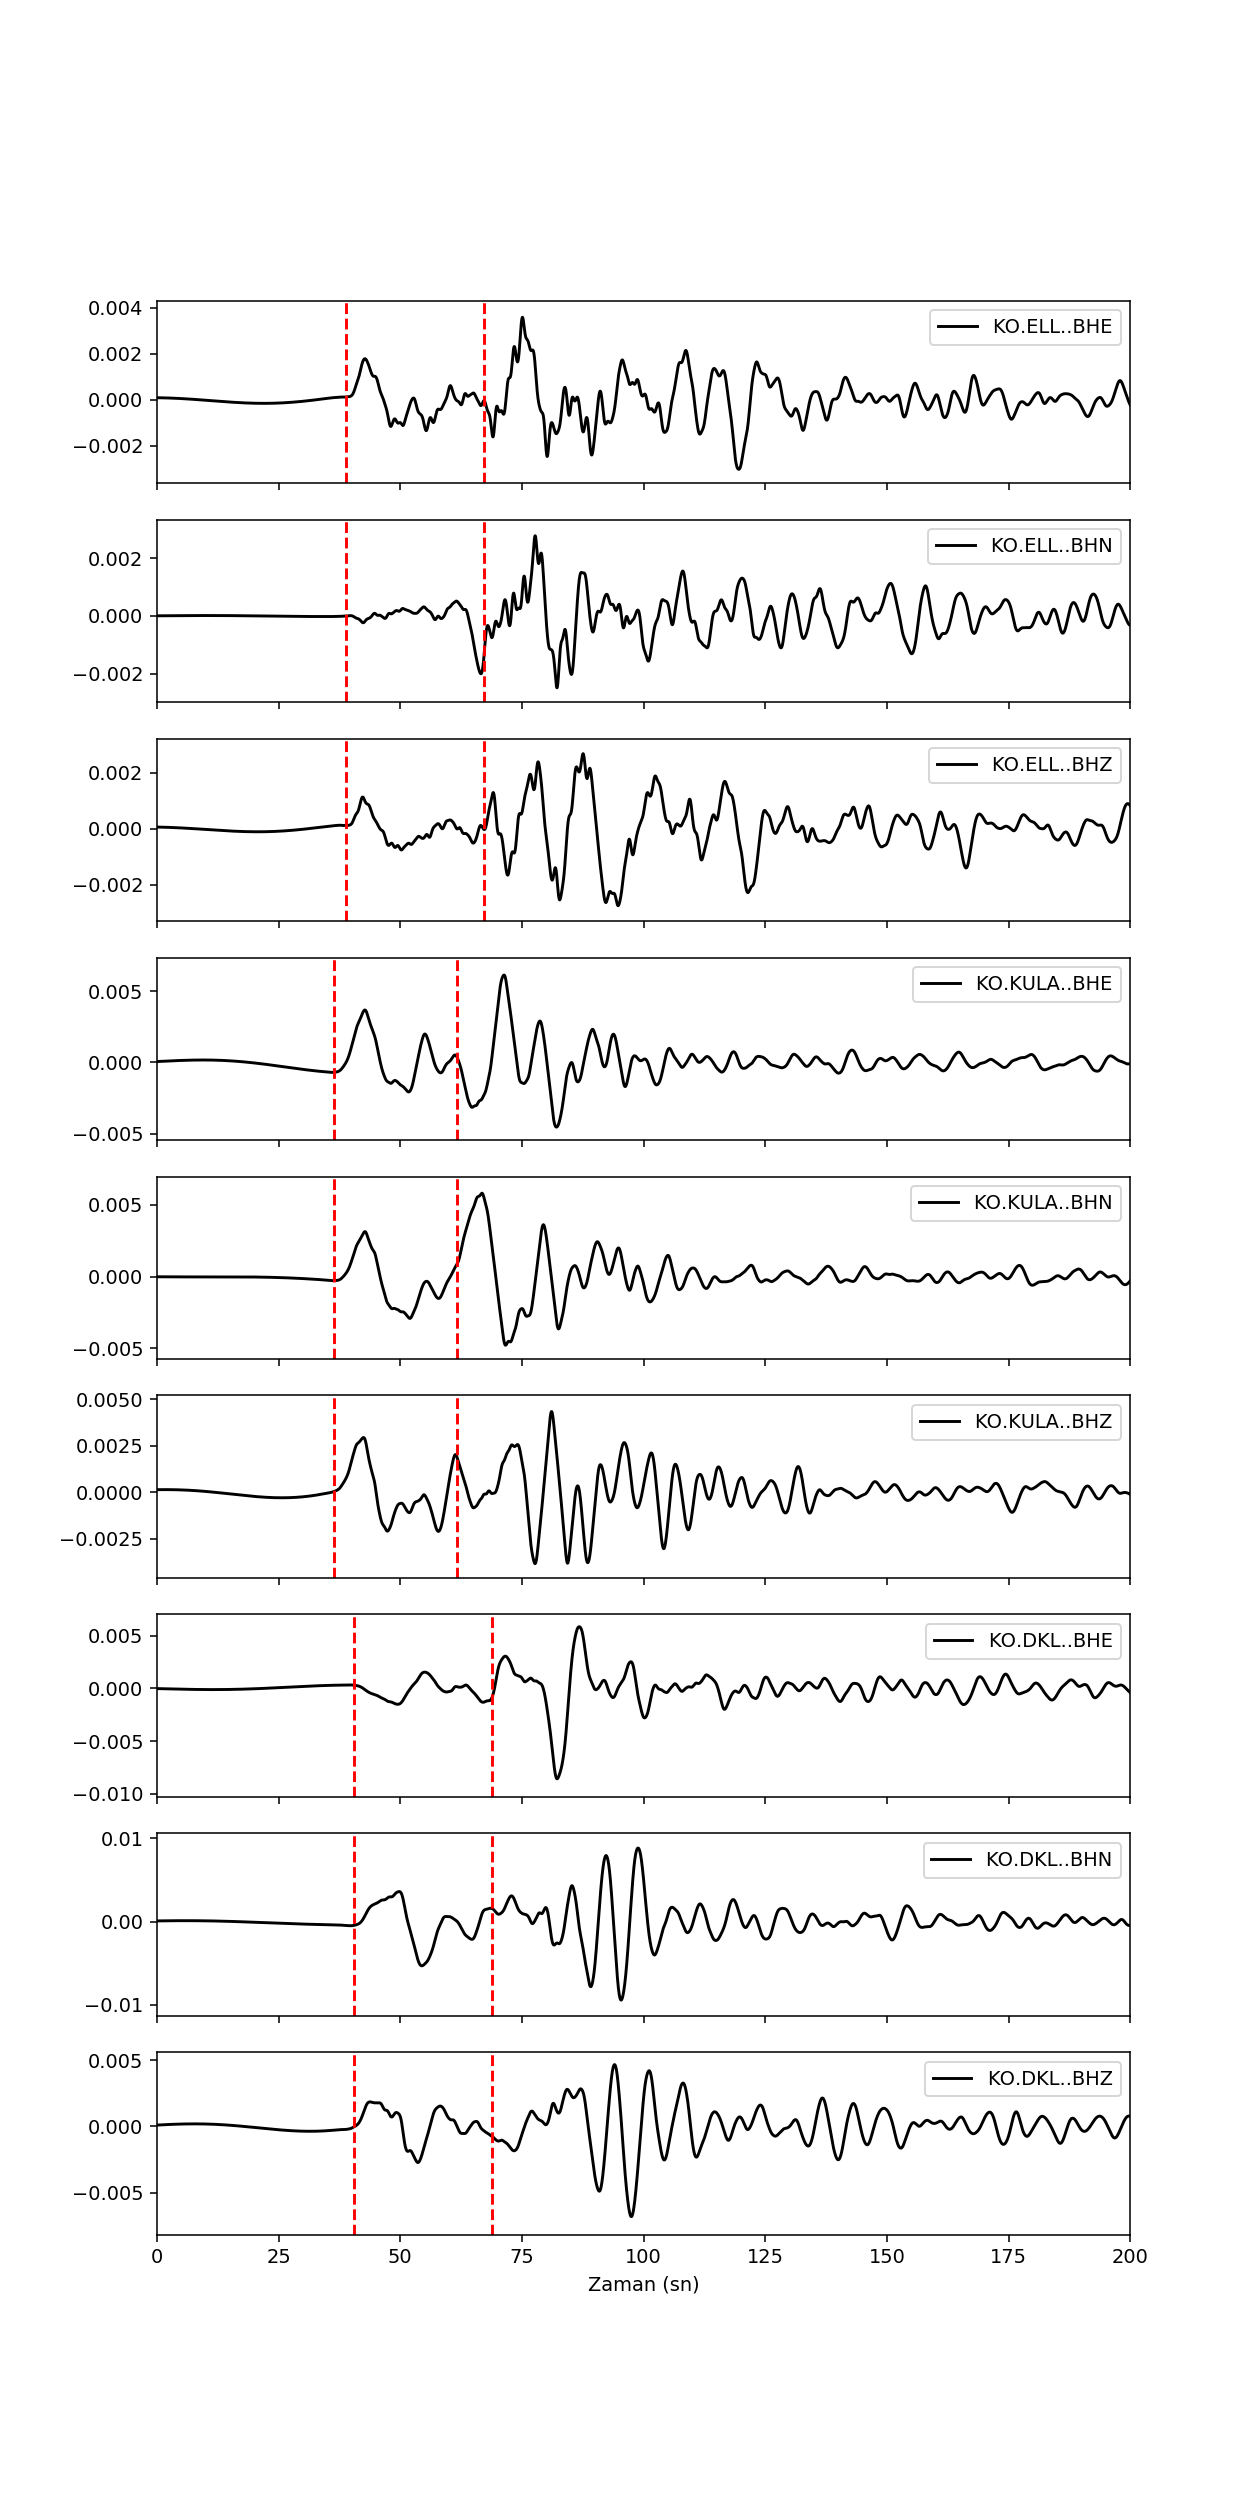

In [19]:
dists = {}
res = plot_pick_and_find_dist(st, dists, (0, 200))

<IPython.core.display.Javascript object>


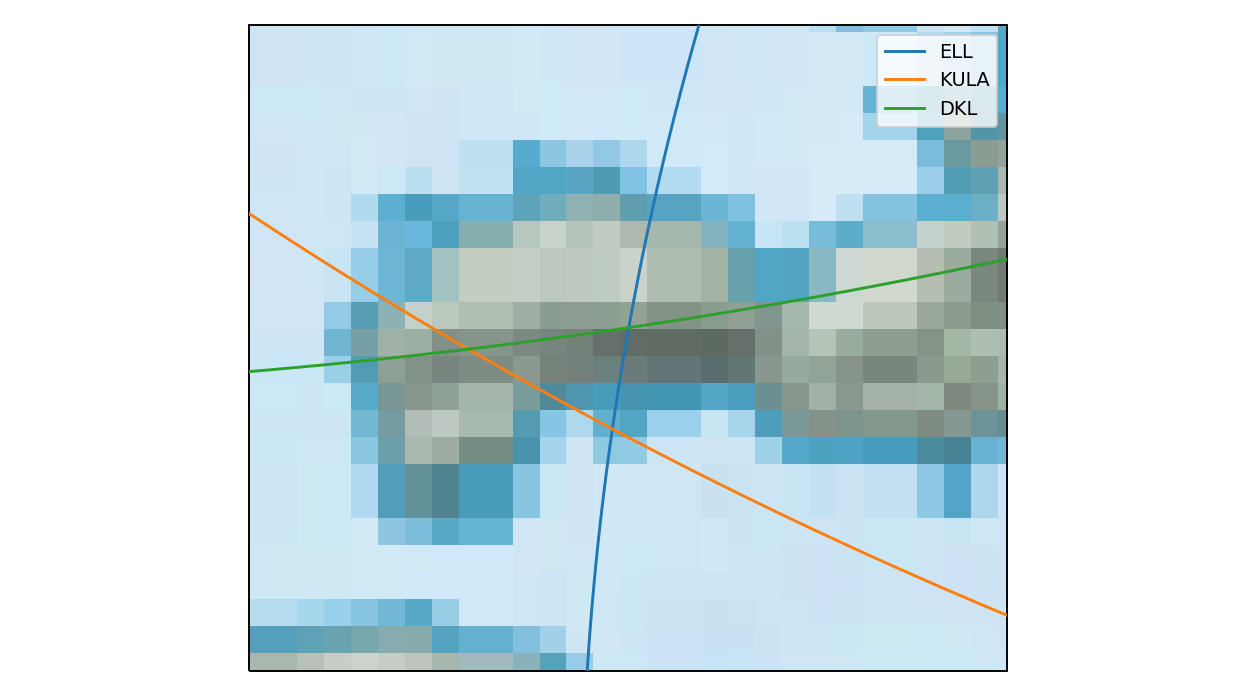

In [20]:
fig, ax = plot_map()
ax.set_extent([26, 32, 35, 42], crs=ccrs.PlateCarree())
ax.scatter(rlons, rlats, 100, color="b", marker="v", transform=ccrs.Geodetic(), zorder=10)

for tr in st:
    if tr.stats.channel == "BHZ":
        coords = inv.get_coordinates(tr.id)
        clats, clons = get_dist_circle(coords["latitude"], coords["longitude"], dists[tr.id])
        ax.plot(clons, clats, transform=ccrs.Geodetic(), label=tr.stats.station, zorder=10)
ax.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


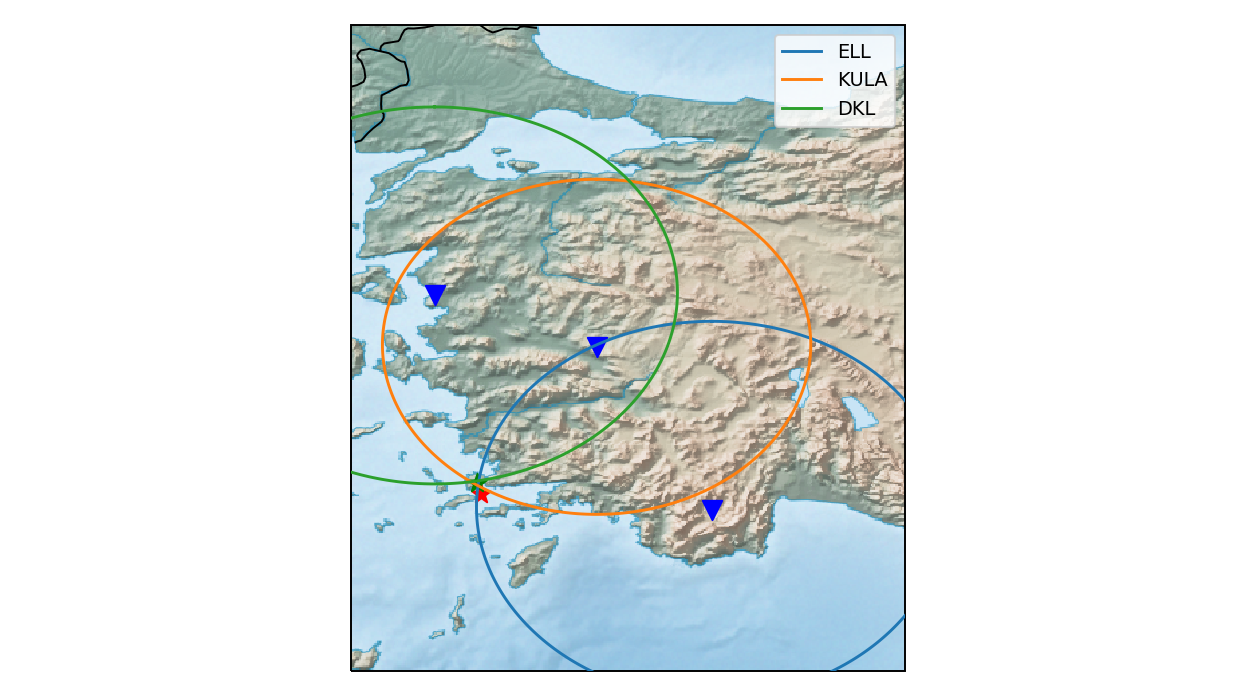

IRIS çözümü ile arasındakı fark: 13.63 km


In [21]:
fig, ax = plot_map()
ax.set_extent([26, 32, 35, 42], crs=ccrs.PlateCarree())
ax.scatter(origin.longitude, origin.latitude, 100, color="r", marker="*", transform=ccrs.Geodetic(), zorder=10)
ax.scatter(rlons, rlats, 100, color="b", marker="v", transform=ccrs.Geodetic(), zorder=10)

mylat = 37.04
mylon = 27.36
ax.scatter(mylon, mylat, 100, color="g", marker="*", transform=ccrs.Geodetic(), zorder=10)

for tr in st:
    if tr.stats.channel == "BHZ":
        coords = inv.get_coordinates(tr.id)
        clats, clons = get_dist_circle(coords["latitude"], coords["longitude"], dists[tr.id])
        ax.plot(clons, clats, transform=ccrs.Geodetic(), label=tr.stats.station, zorder=10)
ax.legend()
plt.tight_layout()

dist, _, _= calc_vincenty_inverse(origin.latitude, origin.longitude, mylat, mylon)
print("IRIS çözümü ile arasındakı fark: {:.2f} km".format(dist/1000))

Kaynaklar:
 1. Sayısal Veriler: http://www.koeri.boun.edu.tr/sismo/2/deprem-verileri/sayisal-veriler/
 2. Bormann, P. New Manual of Seismological Observatory Practice (NMSOP) (GeoForschungsZentrum, 2002).
